In [1]:
import json
import os
import string
import re
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from preprocessing.MILP_Algorithm import select_LP_optimal_subsequence
import numpy as np
from sklearn import tree
from tqdm import tqdm
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, operator
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy import stats


# Read the data

In [2]:
eval_pred = open("data/milp_SQuAD1.1_eval_pred.txt", "r")
test_pred = open("data/milp_SQuAD1.1_test_pred.txt", "r")
y2_eval = open("data/milp_SQuAD1.1_y2_eval.txt", "r")
y3_eval = open("data/milp_SQuAD1.1_y3_eval.txt", "r")
y2_test = open("data/milp_SQuAD1.1_y2_test.txt", "r")
y3_test = open("data/milp_SQuAD1.1_y3_test.txt", "r")
token_type_eval = open("data/milp_SQuAD1.1_token_type_eval.txt", "r")
token_type_test = open("data/milp_SQuAD1.1_token_type_test.txt", "r")
input_ids_test = open("data/milp_SQuAD1.1_input_ids_test.txt", "r")

eval_pred  = json.loads(eval_pred.read())
test_pred  = json.loads(test_pred.read())
y2_eval  = json.loads(y2_eval.read())
y3_eval  = json.loads(y3_eval.read())
y2_test  = json.loads(y2_test.read())
y3_test  = json.loads(y3_test.read())
token_type_eval  = json.loads(token_type_eval.read())
token_type_test  = json.loads(token_type_test.read())
input_ids_test  = json.loads(input_ids_test.read())

eval_pred = [[0 if math.isnan(y) else y for y in x] for x in eval_pred]
test_pred = [[0 if math.isnan(y) else y for y in x] for x in test_pred]


In [3]:
# set max length value
max_len = 300
# Create the tokenizer
save_path = os.path.expanduser("~") + "/.bert_base_uncased/"
if not os.path.exists(save_path):
    slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    os.makedirs(save_path)
    slow_tokenizer.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(save_path + "vocab.txt", lowercase=True)


# MILP
## Using a Decision tree to find the answerability threshold

In [4]:
eval_pred_start_end = []
with tqdm(total=len(eval_pred)) as pbar:
    for idx, probabilities in enumerate(eval_pred):
        start_context_idx = token_type_eval[idx].index(1)
        end_context_idx = len(token_type_eval[idx]) - 1 - token_type_eval[idx][::-1].index(1)
        s_pred,e_pred,_ = select_LP_optimal_subsequence(probabilities[start_context_idx:end_context_idx+1]) # do not consider element at index 0        
        eval_pred_start_end.append([s_pred+start_context_idx, e_pred+start_context_idx])  
        pbar.update(1)


  0%|          | 0/4517 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2021-07-22
Using license file /home/reda/gurobi.lic


100%|██████████| 4517/4517 [18:19<00:00,  4.11it/s]


In [5]:
test_pred_start_end = []
with tqdm(total=len(test_pred)) as pbar:
    for idx, probabilities in enumerate(test_pred):
        start_context_idx = token_type_test[idx].index(1)
        end_context_idx = len(token_type_test[idx]) - 1 - token_type_test[idx][::-1].index(1)
        s_pred, e_pred,_ = select_LP_optimal_subsequence(probabilities[start_context_idx:end_context_idx+1]) # do not consider element at index 0        
        test_pred_start_end.append([s_pred+start_context_idx, e_pred+start_context_idx])  
        pbar.update(1)


100%|██████████| 10400/10400 [44:06<00:00,  3.93it/s] 


## Compute performance

In [6]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text



In [8]:
count_MILP = []
p_MILP = []
r_MILP = []
f1_MILP = []


with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        s_pred = s_pred_e_pred[0]
        e_pred = s_pred_e_pred[1]        
        prediction = input_ids_test[idx][s_pred:e_pred+1]
        ans = input_ids_test[idx][y3_test[idx][0]:y3_test[idx][-1]+1]
        normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
        normalized_true_ans = normalize_text(tokenizer.decode(ans))
        if normalized_pred_ans == normalized_true_ans:
            count_MILP.append(1)
        else:
            count_MILP.append(0)
        prediction = set(normalized_pred_ans.split(' '))
        true = set(normalized_true_ans.split(' '))
        inter = set(prediction & true)
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(true)  
        f1_ = 0
        if (p_+r_) !=0:
            f1_ = 2*p_*r_ / (p_+r_)
        p_MILP.append(p_)
        r_MILP.append(r_)
        f1_MILP.append(f1_)
        pbar.set_description(f"[EM={np.mean(count_MILP):.3f}±{(1.96 * np.std(count_MILP))/np.sqrt(len(count_MILP)):.3f}|F1={np.mean(f1_MILP):.3f}±{(1.96 * np.std(f1_MILP))/np.sqrt(len(f1_MILP)):.3f}|P={np.mean(p_MILP):.3f}±{(1.96 * np.std(p_MILP))/np.sqrt(len(p_MILP)):.3f}|R={np.mean(r_MILP):.3f}±{(1.96 * np.std(r_MILP))/np.sqrt(len(r_MILP)):.3f}]")    
        pbar.update(1)
        




[EM=0.638±0.009|F1=0.805±0.006|P=0.814±0.007|R=0.849±0.006]: 100%|██████████| 10400/10400 [00:44<00:00, 235.55it/s]


# Baseline 1
## Using a Decision tree to find the answerability threshold

In [9]:
eval_pred_start_baseline1 = open("data/Baseline1_SQuAD1.1_eval_pred_start.txt", "r")
eval_pred_end_baseline1 = open("data/Baseline1_SQuAD1.1_eval_pred_end.txt", "r")
test_pred_start_baseline1 = open("data/Baseline1_SQuAD1.1_test_pred_start.txt", "r")
test_pred_end_baseline1 = open("data/Baseline1_SQuAD1.1_test_pred_end.txt", "r")
y2_eval_baseline1 = open("data/Baseline1_SQuAD1.1_y2_eval.txt", "r")
y3_eval_baseline1 = open("data/Baseline1_SQuAD1.1_y3_eval.txt", "r")
y2_test_baseline1 = open("data/Baseline1_SQuAD1.1_y2_test.txt", "r")
y3_test_baseline1 = open("data/Baseline1_SQuAD1.1_y3_test.txt", "r")
token_type_eval_baseline1 = open("data/Baseline1_SQuAD1.1_token_type_eval.txt", "r")
token_type_test_baseline1 = open("data/Baseline1_SQuAD1.1_token_type_test.txt", "r")
input_ids_test_baseline1 = open("data/Baseline1_SQuAD1.1_input_ids_test.txt", "r")

eval_pred_start_baseline1  = json.loads(eval_pred_start_baseline1.read())
eval_pred_end_baseline1  = json.loads(eval_pred_end_baseline1.read())
test_pred_start_baseline1  = json.loads(test_pred_start_baseline1.read())
test_pred_end_baseline1  = json.loads(test_pred_end_baseline1.read())
y2_eval_baseline1  = json.loads(y2_eval_baseline1.read())
y3_eval_baseline1  = json.loads(y3_eval_baseline1.read())
y2_test_baseline1  = json.loads(y2_test_baseline1.read())
y3_test_baseline1  = json.loads(y3_test_baseline1.read())


token_type_eval_baseline1  = json.loads(token_type_eval_baseline1.read())
token_type_test_baseline1  = json.loads(token_type_test_baseline1.read())
input_ids_test_baseline1  = json.loads(input_ids_test_baseline1.read())

eval_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_start_baseline1]
eval_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in eval_pred_end_baseline1]
test_pred_start_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_start_baseline1]
test_pred_end_baseline1 = [[0 if math.isnan(y) else y for y in x] for x in test_pred_end_baseline1]


In [10]:
count_Baseline1 = []
p_Baseline1 = []
r_Baseline1 = []
f1_Baseline1 = []

with tqdm(total=len(test_pred_start_baseline1)) as pbar:
    for idx, (start, end) in enumerate(zip(test_pred_start_baseline1, test_pred_end_baseline1)): 
        start_context_idx = token_type_test_baseline1[idx].index(1)
        end_context_idx = len(token_type_test_baseline1[idx]) - 1 - token_type_test_baseline1[idx][::-1].index(1)        
        s_pred = np.argmax(start[start_context_idx:end_context_idx+1]) + start_context_idx
        e_pred = np.argmax(end[start_context_idx:end_context_idx+1]) + start_context_idx         
        prediction = input_ids_test_baseline1[idx][s_pred:e_pred+1]            
        ans = input_ids_test_baseline1[idx][y3_test[idx][0]:y3_test[idx][-1]+1]            
        normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
        normalized_true_ans = normalize_text(tokenizer.decode(ans))            
        prediction = set(normalized_pred_ans.split(' '))
        true = set(normalized_true_ans.split(' '))
        inter = list(prediction & true)
        if len(prediction) == 0:
            p_Baseline1.append(0)
            r_Baseline1.append(0)
            f1_Baseline1.append(0)
            count_Baseline1.append(0)
            pbar.update(1)
            continue
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(ans)
        f1_ = 0
        if (p_+r_) !=0:
            f1_ = 2*p_*r_ / (p_+r_)
        if f1_ == 1:
            count_Baseline1.append(1)
        else:
            count_Baseline1.append(0)
        p_Baseline1.append(p_)
        r_Baseline1.append(r_)
        f1_Baseline1.append(f1_)
        pbar.set_description(f"[EM={np.mean(count_Baseline1):.3f}±{(1.96 * np.std(count_Baseline1))/np.sqrt(len(count_Baseline1)):.3f}|F1={np.mean(f1_Baseline1):.3f}±{(1.96 * np.std(f1_Baseline1))/np.sqrt(len(f1_Baseline1)):.3f}|P={np.mean(p_Baseline1):.3f}±{(1.96 * np.std(p_Baseline1))/np.sqrt(len(p_Baseline1)):.3f}|R={np.mean(r_Baseline1):.3f}±{(1.96 * np.std(r_Baseline1))/np.sqrt(len(r_Baseline1)):.3f}]")
        pbar.update(1)
    


[EM=0.332±0.009|F1=0.691±0.006|P=0.822±0.007|R=0.665±0.007]: 100%|██████████| 10400/10400 [00:44<00:00, 231.94it/s]


# Baseline 2

In [11]:
def baseline2(A):
    B = np.where(np.array(A) > 0.5, 1, 0)
    if np.sum(B) == 0:
        return -1, -1
    else:
        r = max((list(y) for (x,y) in itertools.groupby((enumerate(B)),operator.itemgetter(1)) if x == 1), key=len)
        return r[0][0], r[-1][0]
    
    

In [12]:
count_Baseline2 = []
p_Baseline2 = []
r_Baseline2 = []
f1_Baseline2 = []


with tqdm(total=len(test_pred_start_end)) as pbar:
    for idx, s_pred_e_pred in enumerate(test_pred_start_end):
        start_context_idx = token_type_test_baseline1[idx].index(1)
        end_context_idx = len(token_type_test_baseline1[idx]) - 1 - token_type_test_baseline1[idx][::-1].index(1)
        probabilities = test_pred[idx][start_context_idx:end_context_idx+1]   
        s_pred, e_pred = baseline2(probabilities)
            
        s_pred = s_pred + start_context_idx
        e_pred = e_pred + start_context_idx

        prediction = input_ids_test_baseline1[idx][s_pred:e_pred+1]            
        ans = input_ids_test_baseline1[idx][y3_test[idx][0]:y3_test[idx][-1]+1]            
        normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
        normalized_true_ans = normalize_text(tokenizer.decode(ans))            
        prediction = set(normalized_pred_ans.split(' '))
        true = set(normalized_true_ans.split(' '))
        inter = list(prediction & true)
        if len(prediction) == 0:
            p_Baseline2.append(0)
            r_Baseline2.append(0)
            f1_Baseline2.append(0)
            count_Baseline2.append(0)
            pbar.update(1)
            continue
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(ans)
        f1_ = 0
        if (p_+r_) !=0:
            f1_ = 2*p_*r_ / (p_+r_)
        if f1_ == 1:
            count_Baseline2.append(1)
        else:
            count_Baseline2.append(0)
        p_Baseline2.append(p_)
        r_Baseline2.append(r_)
        f1_Baseline2.append(f1_)
        pbar.set_description(f"[EM={np.mean(count_Baseline2):.3f}±{(1.96 * np.std(count_Baseline2))/np.sqrt(len(count_Baseline2)):.3f}|F1={np.mean(f1_Baseline2):.3f}±{(1.96 * np.std(f1_Baseline2))/np.sqrt(len(f1_Baseline2)):.3f}|P={np.mean(p_Baseline2):.3f}±{(1.96 * np.std(p_Baseline2))/np.sqrt(len(p_Baseline2)):.3f}|R={np.mean(r_Baseline2):.3f}±{(1.96 * np.std(r_Baseline2))/np.sqrt(len(r_Baseline2)):.3f}]")
        pbar.update(1)



[EM=0.317±0.009|F1=0.664±0.007|P=0.807±0.007|R=0.618±0.007]: 100%|██████████| 10400/10400 [00:45<00:00, 230.34it/s]


# Plots

In [13]:
data = pd.DataFrame(columns=['algo','accuracy','f1', 'precision',  'recall'])
data_list = list(zip(['MILP']*len(count_MILP), count_MILP, f1_MILP, p_MILP, r_MILP))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 1']*len(count_Baseline2), count_Baseline1, f1_Baseline1, p_Baseline1, r_Baseline1))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 2']*len(count_Baseline2), count_Baseline2, f1_Baseline2, p_Baseline2, r_Baseline2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)




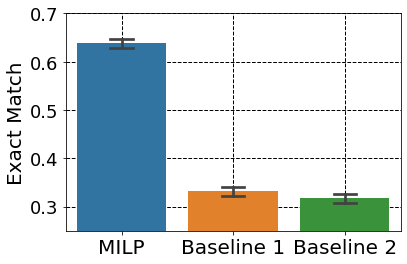

In [29]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Exact Match")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.25, 0.70)
plt.savefig('plots/em_SQuAD1.1.eps', bbox_inches = 'tight')
plt.show()


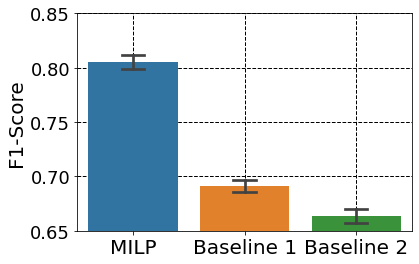

In [22]:
# statistic, pvalue = stats.ttest_ind(f1_2, f1_baseline2)
ax = sns.barplot(x="algo", y="f1", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("F1-Score")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.savefig('plots/f1_score_SQuAD1.1.eps', bbox_inches = 'tight')
plt.show()


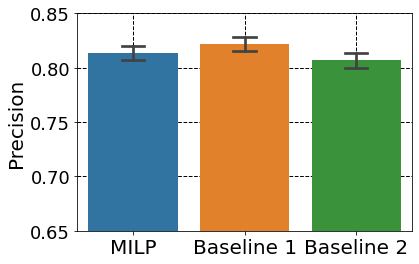

In [23]:
# statistic, pvalue = stats.ttest_ind(p2, p_baseline2)
ax = sns.barplot(x="algo", y="precision", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Precision")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.savefig('plots/precision_SQuAD1.1.eps', bbox_inches = 'tight')
plt.show()


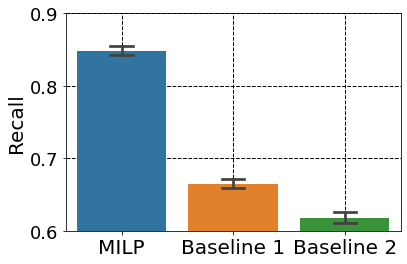

In [27]:
# statistic, pvalue = stats.ttest_ind(r2, r_baseline2)
ax = sns.barplot(x="algo", y="recall", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} < 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Recall")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.6, 0.90)
plt.savefig('plots/recall_SQuAD1.1.eps', bbox_inches = 'tight')
plt.show()


In [28]:
# This part is for the statistical tests
p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='Baseline 1']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='Baseline 1']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='Baseline 1']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='Baseline 1']['recall'])[1]
print('\\textbf{MILP vs. Baseline 2} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f}\\\\' )

p_value_em = stats.ttest_ind(data[data['algo']=='MILP']['accuracy'], data[data['algo']=='Baseline 2']['accuracy'])[1]
p_value_f1 = stats.ttest_ind(data[data['algo']=='MILP']['f1'], data[data['algo']=='Baseline 2']['f1'])[1]
p_value_precision = stats.ttest_ind(data[data['algo']=='MILP']['precision'], data[data['algo']=='Baseline 2']['precision'])[1]
p_value_recall = stats.ttest_ind(data[data['algo']=='MILP']['recall'], data[data['algo']=='Baseline 2']['recall'])[1]
print('\\textbf{MILP vs. Baseline 2} &', f'{p_value_em:.4f} & {p_value_f1:.4f} & {p_value_precision:.4f} & {p_value_recall:.4f}\\\\' )



\textbf{MILP vs. Baseline 2} & 0.0000 & 0.0000 & 0.0750 & 0.0000\\
\textbf{MILP vs. Baseline 2} & 0.0000 & 0.0000 & 0.1660 & 0.0000\\
